# Compare Results

Compare grid search results from 40 maximum iterations with conversion after 20 iterations with grid search results from 10 maximum iterations with conversion after 10 iterations.

Question: Can we still get good results when we decrease the number of iterations? This would speed things up!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from skopt import gp_minimize
from skopt.callbacks import DeltaXStopper

In [2]:
# Approved plan results
dose_approved = 2000
volume_approved = 10
oar_avg_approved = 318.4594544159879
ptv_d95_approved = 4800.13222492 
dvh_doses_approved = np.load('approved/dvh_doses_approved.npy')
dvh_oar_approved = np.load('approved/dvh_oar_approved.npy')
dvh_ptv_approved = np.load('approved/dvh_ptv_approved.npy')

In [3]:
# Grid search results (40)
oar_avg_40 = np.load('grid_search_40/oar_avg.npy')
ptv_d95_40 = np.load('grid_search_40/ptv_d95.npy')
oar_avg_norm_40 = np.load('grid_search_40/oar_avg_norm.npy')
ptv_d95_norm_40 = np.load('grid_search_40/ptv_d95_norm.npy')
dvh_doses_40 = np.load('grid_search_40/dvh_doses.npy')
dvh_doses_norm_40 =  np.load('grid_search_40/dvh_doses_norm.npy')
dvh_oar_40 = np.load('grid_search_40/dvh_oar.npy')
dvh_oar_norm_40 = np.load('grid_search_40/dvh_oar_norm.npy')
dvh_ptv_40 = np.load('grid_search_40/dvh_ptv.npy')
dvh_ptv_norm_40 = np.load('grid_search_40/dvh_ptv_norm.npy')

In [4]:
# Grid search results (40)
oar_avg_10 = np.load('grid_search_10/oar_avg.npy')
ptv_d95_10 = np.load('grid_search_10/ptv_d95.npy')
oar_avg_norm_10 = np.load('grid_search_10/oar_avg_norm.npy')
ptv_d95_norm_10 = np.load('grid_search_10/ptv_d95_norm.npy')
dvh_doses_10 = np.load('grid_search_10/dvh_doses.npy')
dvh_doses_norm_10 =  np.load('grid_search_10/dvh_doses_norm.npy')
dvh_oar_10 = np.load('grid_search_10/dvh_oar.npy')
dvh_oar_norm_10 = np.load('grid_search_10/dvh_oar_norm.npy')
dvh_ptv_10 = np.load('grid_search_10/dvh_ptv.npy')
dvh_ptv_norm_10 = np.load('grid_search_10/dvh_ptv_norm.npy')

In [5]:
def plot_grid(results_vec, results_name, point=None):
    """Plot results as a grid."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Contour plot
    im0 = ax[0].contour(results_vec[1:, :].T)
    ax[0].clabel(im0)
    ax[0].set_xticks(ticks=np.arange(1, 21, 2))
    ax[0].set_xticklabels(labels=np.arange(200, 2001, 200), rotation=90)
    ax[0].set_xlabel('OAR Dose Parameter')
    ax[0].set_ylabel('OAR Volume Parameter')
    
    # Grid plot
    im1 = ax[1].imshow(results_vec[1:, :].T, origin='lower')
    ax[1].set_xticks(ticks=np.arange(1, 21, 2))
    ax[1].set_xticklabels(labels=np.arange(200, 2001, 200), rotation=90)
    ax[1].set_xlabel('OAR Dose Parameter')
    ax[1].set_ylabel('OAR Volume Parameter')
    ax[1].axis('auto')
    plt.colorbar(im1, label=results_name)
    
    # Plot point
    if point is not None:
        ax[0].plot(point[0] - 1, point[1], 'ro')
        ax[1].plot(point[0] - 1, point[1], 'ro')

## Compare grid search results

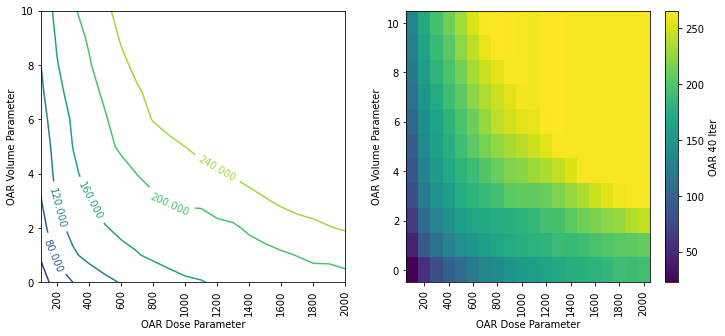

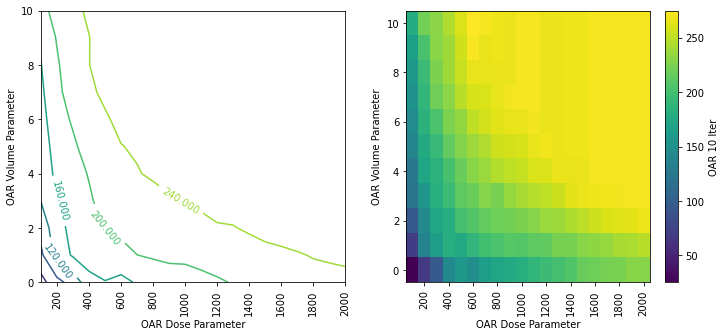

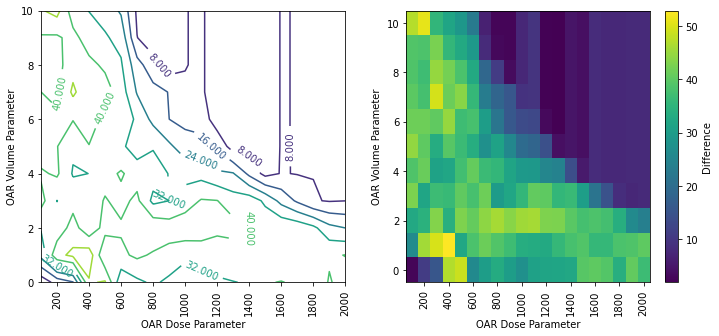

In [6]:
# OAR values
plot_grid(oar_avg_40, 'OAR 40 Iter')
plot_grid(oar_avg_10, 'OAR 10 Iter')
plot_grid(abs(oar_avg_40 - oar_avg_10), 'Difference')

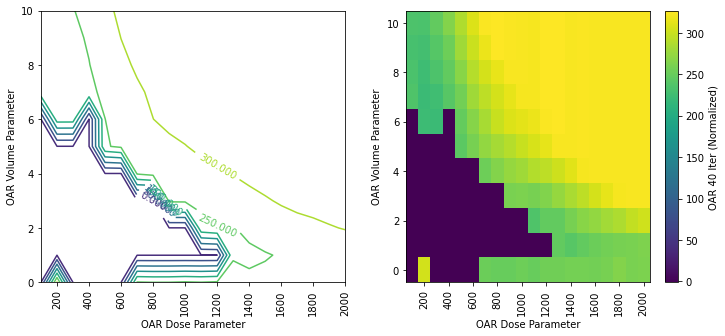

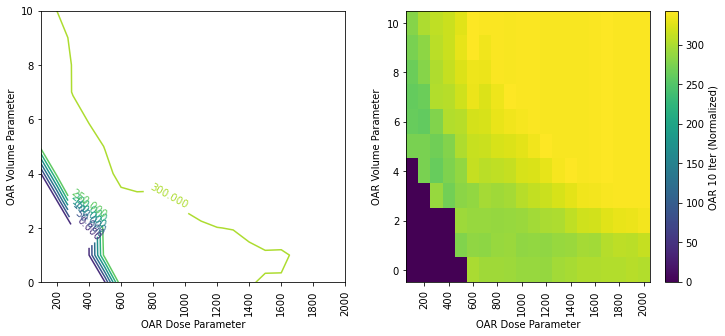

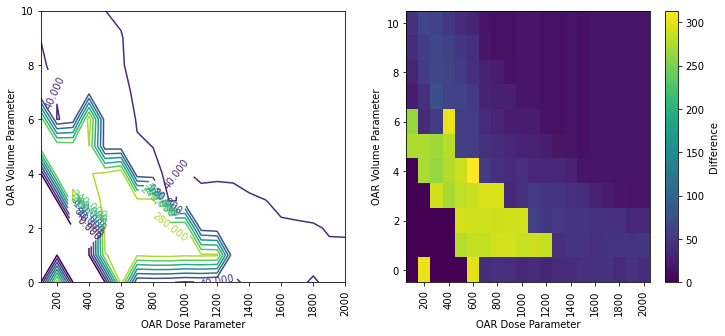

In [7]:
# OAR values (normalized)
plot_grid(oar_avg_norm_40, 'OAR 40 Iter (Normalized)')
plot_grid(oar_avg_norm_10, 'OAR 10 Iter (Normalized)')
plot_grid(abs(oar_avg_norm_40 - oar_avg_norm_10), 'Difference')

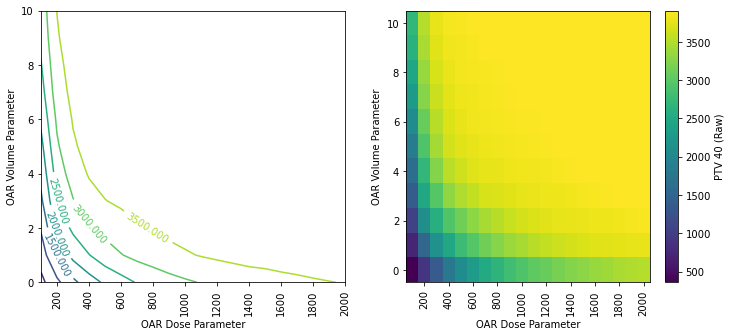

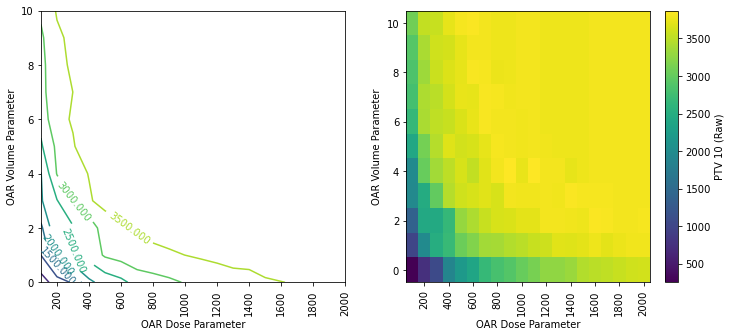

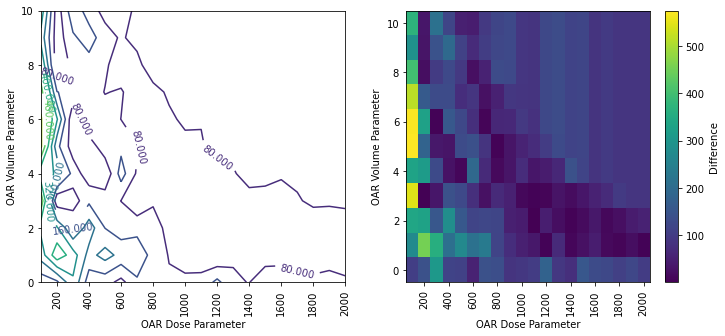

In [8]:
# PTV values
plot_grid(ptv_d95_40, 'PTV 40 (Raw)')
plot_grid(ptv_d95_10, 'PTV 10 (Raw)')
plot_grid(abs(ptv_d95_40 - ptv_d95_10), 'Difference')

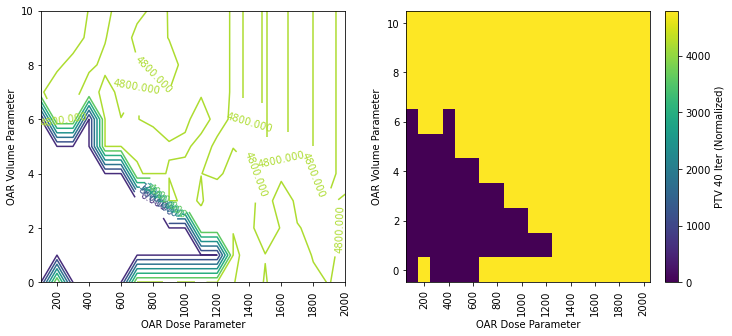

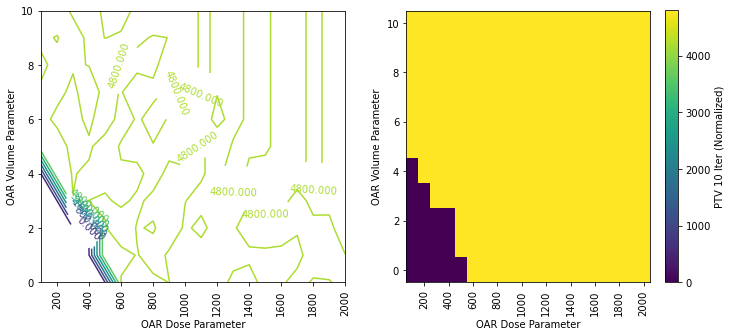

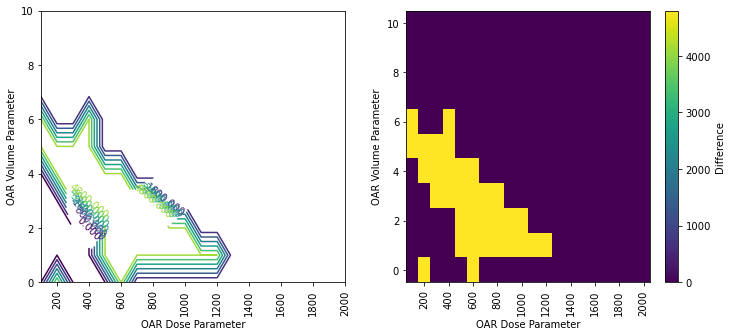

In [9]:
# PTV values (normalized)
plot_grid(ptv_d95_norm_40, 'PTV 40 Iter (Normalized)')
plot_grid(ptv_d95_norm_10, 'PTV 10 Iter (Normalized)')
plot_grid(abs(ptv_d95_norm_40 - ptv_d95_norm_10), 'Difference')

Looks like values on the border of good plans and bad plans are where they differ the most.
This probably isn't good, because the optimal plan will probably be in that region.
Could look into 20, 30 iterations, etc., to see the lowest we could use...

## Compare Bayesian optimization results

###  Interpolate OAR average dose

In [10]:
# Get rid of zero dose values
oar_avg = oar_avg_10[1:, :]
ptv_d95 = ptv_d95_10[1:, :]
oar_avg_norm = oar_avg_norm_10[1:, :]
ptv_d95_norm = ptv_d95_norm_10[1:, :]

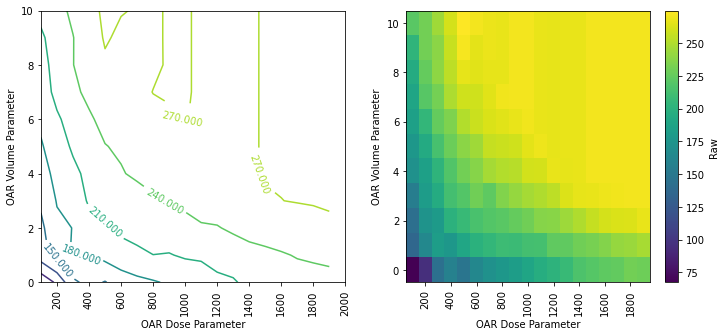

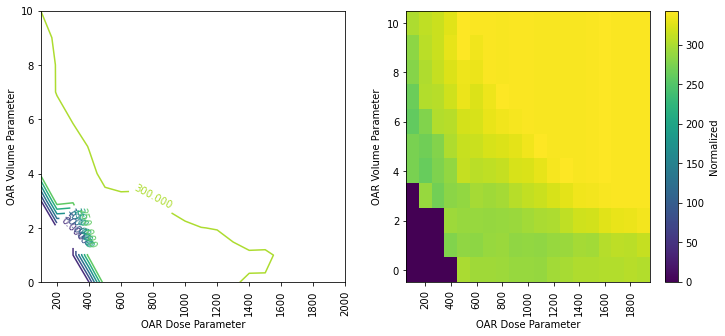

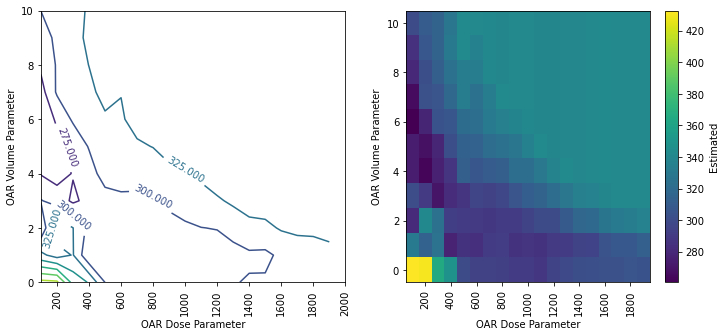

In [11]:
# Normalized data with estimated values
idx = oar_avg_norm == -1
oar_avg_est = oar_avg_norm.copy()
oar_avg_est[idx] = 4800*oar_avg[idx]/ptv_d95[idx]
plot_grid(oar_avg, 'Raw')
plot_grid(oar_avg_norm, 'Normalized')
plot_grid(oar_avg_est, 'Estimated')

In [12]:
oar_avg_est.shape

(20, 11)

Dose: 100, Volume: 6, Min dose: 260.578174635882


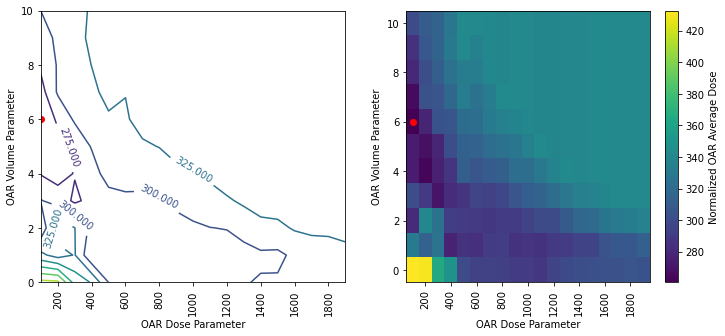

In [13]:
# Find optimal point
min_dose = 1e6
opt_dose = -1
opt_volume = -1
for ii in range(1, 20):
    for jj in range(1, 11):
        if oar_avg_est[ii, jj] < min_dose:
            min_dose = oar_avg_est[ii, jj]
            opt_dose =  ii
            opt_volume = jj
print(f'Dose: {100*opt_dose}, Volume: {opt_volume}, Min dose: {min_dose}')

# Plot results with optimal point
plot_grid(oar_avg_est, 'Normalized OAR Average Dose', point=[opt_dose, opt_volume]);

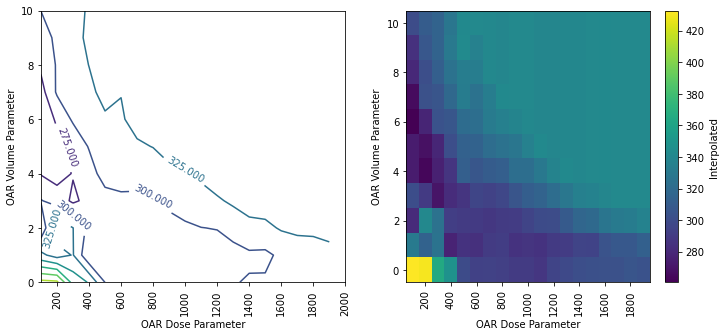

In [14]:
# Make sure same input produces same output
volumes = np.arange(0, 11)
doses = np.arange(100, 2001, 100)
oar_avg_func = interpolate.interp2d(volumes, doses, oar_avg_est)
plot_grid(oar_avg_func(volumes, doses), 'Interpolated')

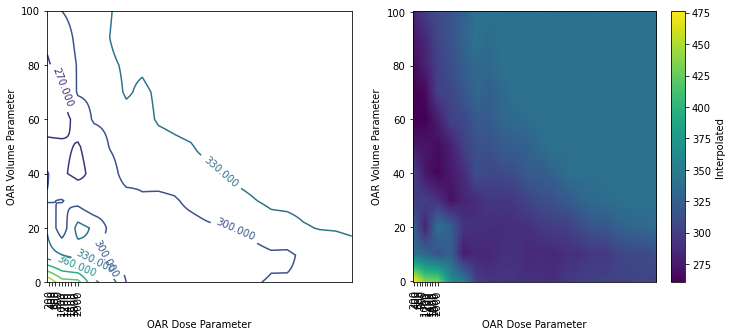

In [15]:
# Now let's look at a finer grid
plot_grid(oar_avg_func(np.arange(0, 10.1, 0.1), np.arange(100, 2001, 10)), 'Interpolated')

In [16]:
# For gp_minimize, input needs to be a single vector, output needs to be scalar
def oar_avg_func2(pars):
    return oar_avg_func(pars[0], pars[1])[0]

/Users/Kelsey/anaconda3/envs/autoray_env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Kelsey/anaconda3/envs/autoray_env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Kelsey/anaconda3/envs/autoray_env/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


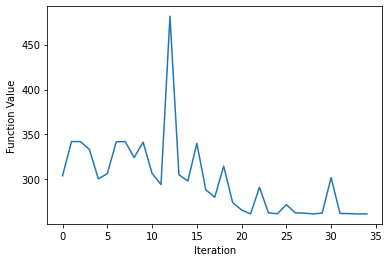

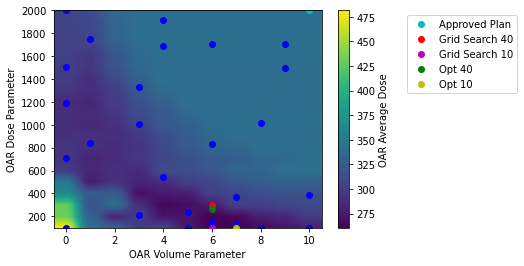

In [17]:
# Optimize
r = gp_minimize(oar_avg_func2, dimensions=[(0, 10), (100, 2000)],
                x0=[0, 2000], y0=oar_avg_func2([0, 2000]),
                random_state=0, callback=DeltaXStopper(1))
v_vals = [r.x_iters[ii][0] for ii in range(len(r.x_iters))]
d_vals = [r.x_iters[ii][1]-100 for ii in range(len(r.x_iters))]

# Plot convergence
plt.plot(r.func_vals)
plt.xlabel('Iteration')
plt.ylabel('Function Value')

# Plot iterates
fig, ax = plt.subplots()
im = ax.imshow(oar_avg_func(np.arange(0, 11), np.arange(100, 2001)), origin='lower')
ax.plot(10, 1900, 'co')
ax.plot(6, 200, 'ro', zorder=3)
ax.plot(6, 0, 'mo', zorder=3)
ax.plot(6, 166, 'go', zorder=3)
ax.plot(v_vals[-1], d_vals[-1], 'yo', zorder=3)
ax.plot(v_vals, d_vals, 'bo')
ax.set_xlabel('OAR Volume Parameter')
ax.set_yticks(np.arange(100, 2001, 200))
ax.set_yticklabels(np.arange(200, 2001, 200))
ax.set_ylabel('OAR Dose Parameter')
ax.axis('auto')
ax.legend(bbox_to_anchor=(1.75, 1), labels=['Approved Plan', 'Grid Search 40', 'Grid Search 10', 'Opt 40', 'Opt 10'])
plt.colorbar(im, label='OAR Average Dose')

## DVH of grid search results

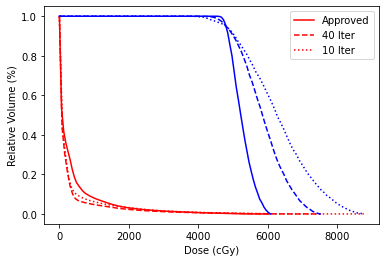

In [18]:
plt.plot(dvh_doses_approved, dvh_oar_approved, 'r')
plt.plot(dvh_doses_norm_40, dvh_oar_norm_40, 'r--')
plt.plot(dvh_doses_norm_10[1, 6, :], dvh_oar_norm_10[1, 6, :], 'r:')

plt.plot(dvh_doses_approved, dvh_ptv_approved, 'b')
plt.plot(dvh_doses_norm_40, dvh_ptv_norm_40, 'b--')
plt.plot(dvh_doses_norm_10[1, 6, :], dvh_ptv_norm_10[1, 6, :], 'b:')

plt.xlabel('Dose (cGy)')
plt.ylabel('Relative Volume (%)')
plt.legend(['Approved', '40 Iter', '10 Iter'])

Definitely need to use the full number of iterations, or at least more than 10!